# Analyse av reelle datasett - elektrisitet

- Data hentet fra https://www.ssb.no/statbank/table/14091 (enhet: mWh)
- Mer statistikk om strømforbruk tilgjengelig i https://www.ssb.no/statbank/table/08307
- Nettoforbruk etter fylke: https://www.ssb.no/statbank/table/08313
  Kan brukes til å sammenligne med lokal temperatur, klimaservicesenter tilbyr ikke temperatur for hele landet som én verdi
- Kan bruke også data for temperatur for å sammenligne de ulike datasettene
  Værdata i så fall fra https://www.met.no/frie-meteorologiske-data/frie-meteorologiske-data
  Sannsynligvis https://klimaservicesenter.no (https://seklima.met.no)

## Mål

- Sammenligne ulike kilder (vann, vind, sol, varme)
- Eksport vs import over tid
- Nettap delt på strømforbruk for å se effektivitet over tid (pf?)
- Forbruk mellom ulike næringer over tid
- Forbruk i husholdninger sammenlignet med temperatur og nedbør

---

- Bruke regresjon

In [202]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm
from datetime import timedelta, datetime

## Laste data

In [200]:
df = pd.read_csv("elektrisitet.csv", delimiter=";", encoding="latin1")
df["Elektrisk kraft"] = df["Elektrisk kraft"].replace("..", np.nan)
df = df.pivot_table(index="måned", values="Elektrisk kraft", columns="produksjon og forbruk", aggfunc="first")
df.reset_index(inplace=True)

df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric)

# df.index = pd.to_datetime(df.index, format='%YM%m')
df["måned"] = pd.to_datetime(df["måned"], format='%YM%m')
# df.set_index("måned", inplace=True)
# df.insert(1, "timestamp", df["måned"].astype(np.int64))

start_date = df["måned"].iat[0]
df.insert(1, "month_number", (df["måned"].dt.year - start_date.year) * 12 + df["måned"].dt.month - start_date.month)

FileNotFoundError: [Errno 2] No such file or directory: 'elektrisitet.csv'

In [133]:
def get_month(month):
    # days = month * 30.44 # Approximate days in month
    # return first_month + timedelta(days=days)
    # Does not need any more precision
    year = start_date.year + (start_date.month - 1 + int(month)) // 12
    month = (start_date.month - 1 + int(month)) % 12 + 1
    return datetime(year, month, 1)

In [3]:
# df.columns = [c.split()[0] for c in df.columns]

## Vindkraft

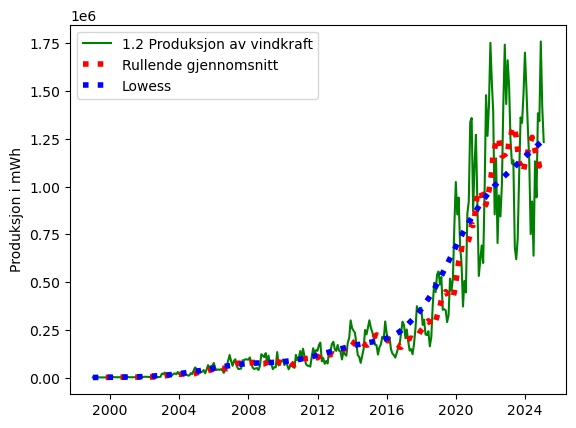

In [80]:
wind = df["1.2 Produksjon av vindkraft"]

wind_lowess = sm.nonparametric.lowess(wind, df.index, frac=0.2, return_sorted=False)
wind_lowess = pd.Series(wind_lowess, df.index, name="Lowess")

wind_smoothed = wind.rolling(window=10).mean().rename("Rullende gjennomsnitt")

plt.plot(df["måned"], wind, label=wind.name, color="g")
plt.plot(df["måned"], wind_smoothed, label=wind_smoothed.name, linestyle=":", linewidth=4, color="r")
plt.plot(df["måned"], wind_lowess, label=wind_lowess.name, linestyle=":", linewidth=4, color="b")

# wind.plot(color="g")
# wind_smoothed.plot(linestyle=":", linewidth=4, color="r")
# wind_lowess.plot(linestyle=":", linewidth=4, color="b")

plt.ylabel("Produksjon i mWh")

plt.legend()

### Regresjonsanalyse

Bruker regresjon for å finne en modell for utviklingen av vindkraftproduksjon i norge.

In [170]:
# Fjerne all data før første måling (alt før er NaN)
first = wind.first_valid_index()
ys = wind.loc[first:]
xs = df["month_number"].loc[first:]
xs_datetime = df["måned"].loc[first:]

#### Eksponentiell vekst

Bruker følgende modell:

$$
f \left( x \right) = a \cdot b ^{t}
$$

---

##### Startverdier

- $a$ er den første verdien i datasettet.
- $b$ er et tall slik at $b > 1$, ellers hadde funksjonen vært avtakende.

In [ ]:
def model_exp(t, a, b):
    return a * b ** t

In [175]:
a = ys.iat[0]
b = 1.1
coeffs_exp, _ = curve_fit(model_exp, xs, ys, p0=[a, b])

#### Logistisk vekst

Bruker følgende modell:

$$
f \left( t \right) = \frac{C}{1 + a \cdot e^{-bt}}
$$

---

##### Startverdier

- $C$ er den høyeste av $y$-verdiene.
- $a$ bestemmer startverdien, og er derfor $\dfrac{C}{y_{0}}-1$. Dette er fordi når $t=0$, vil $e^{-bt}$ være lik $1$.
- $b$ er en verdi slik at $b > 0$, da det ellers ikke blir noen vekst.

In [178]:
def model_logistic(t, a, b, C):
    return C / (1 + a * np.exp(-b * t))

In [188]:
C = ys.max()
a = C / ys.iat[0] - 1
b = 0.01
coeffs_logistic, _ = curve_fit(model_logistic, xs, ys, p0=[a, b, C])

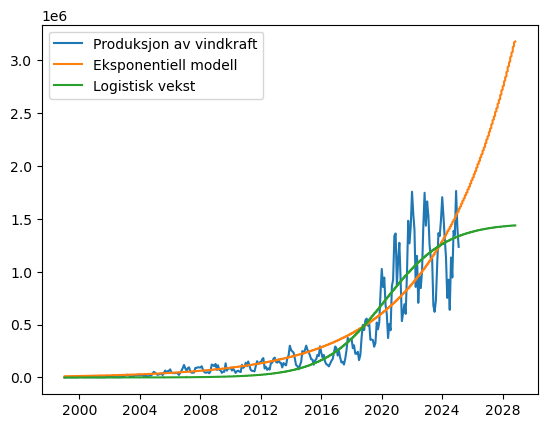

In [189]:
xs_model = np.linspace(first, 430, 2000)
ys_exp = model_exp(xs_model, *coeffs_exp)
ys_logistic = model_logistic(xs_model, *coeffs_logistic)
xs_model = [get_month(m) for m in xs_model]

plt.plot(xs_datetime, ys, label="Produksjon av vindkraft")
plt.plot(xs_model, ys_exp, label="Eksponentiell modell")
plt.plot(xs_model, ys_logistic, label="Logistisk vekst")

plt.legend()